In [1]:
from datasets import load_dataset, VerificationMode
from collections import defaultdict
from teren.typing import *
import plotly.express as px

SEQ_LEN = 8
LAYER = 1
INFERENCE_TOKENS = 12_800
INFERENCE_BATCH_SIZE = INFERENCE_TOKENS // SEQ_LEN
print(f"{INFERENCE_BATCH_SIZE=}")
N_PROMPTS = INFERENCE_BATCH_SIZE * 5
MIN_ACT = 0.0

dataset = load_dataset(
    "apollo-research/Skylion007-openwebtext-tokenizer-gpt2",
    data_files="data/train-00000-of-00073.parquet",
    verification_mode=VerificationMode.NO_CHECKS,
    split="train",
)
dataset.set_format(type="torch")
input_ids = dataset["input_ids"].view(-1, SEQ_LEN)[:N_PROMPTS]

INFERENCE_BATCH_SIZE=1600


In [2]:
from transformer_lens import HookedTransformer
import torch
from teren import utils as teren_utils
from teren.typing import *
from tqdm.auto import trange, tqdm


device = teren_utils.get_device_str()
print(f"{device=}")
torch.set_grad_enabled(False)
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

device='cuda'
Loaded pretrained model gpt2-small into HookedTransformer


### hook points

In [3]:
n_layers = model.cfg.n_layers
all_hook_points = [f"blocks.{layer}.hook_resid_pre" for layer in range(n_layers)]
all_hook_points.append(f"blocks.{n_layers-1}.hook_resid_post")

### collect activations & logits

In [4]:
all_resid_acts = torch.empty(N_PROMPTS, SEQ_LEN, model.cfg.d_model)
all_logits = torch.empty(N_PROMPTS, model.cfg.d_vocab)

hook_point = all_hook_points[LAYER]
for i in trange(0, N_PROMPTS, INFERENCE_BATCH_SIZE):
    # no need to move to device, as long as model is on a correct device
    batch_input_ids = input_ids[i : i + INFERENCE_BATCH_SIZE]
    batch_logits, cache = model.run_with_cache(
        batch_input_ids,
        names_filter=hook_point,
        return_type="logits",
    )
    # only last position
    all_logits[i : i + INFERENCE_BATCH_SIZE] = batch_logits[:, -1]
    batch_resid_acts = cache[hook_point]
    all_resid_acts[i : i + INFERENCE_BATCH_SIZE] = batch_resid_acts

  0%|          | 0/5 [00:00<?, ?it/s]

### load SAE

In [5]:
SAE_BATCH_SIZE = INFERENCE_BATCH_SIZE
from teren.saes import SAE_ID_BY_LAYER_BY_FAMILY
from sae_lens import SAE

sae_family = "gpt2-small-res-jb"
sae_id = SAE_ID_BY_LAYER_BY_FAMILY[sae_family][LAYER]
sae, _, log_sparsities = SAE.from_pretrained(
    release=sae_family, sae_id=sae_id, device=device
)

### find which features are active at last position

In [6]:
fid_to_prompt_idx = defaultdict(list)
fid_to_f_acts = defaultdict(list)
all_last_pos_resid_acts = all_resid_acts[:, -1]

for i in trange(0, N_PROMPTS, SAE_BATCH_SIZE):
    batch_last_pos_resid_acts = all_last_pos_resid_acts[i : i + SAE_BATCH_SIZE].to(
        device
    )

    # shape: (batch_size, d_sae)
    batch_f_acts = sae.encode(batch_last_pos_resid_acts)
    for fid in range(sae.cfg.d_sae):
        this_batch_f_acts = batch_f_acts[:, fid]
        mask = this_batch_f_acts > MIN_ACT
        if not mask.any():
            continue
        # 1 dim, dynamic shape
        fid_to_f_acts[fid] += this_batch_f_acts[mask].tolist()
        fid_to_prompt_idx[fid] += torch.arange(i, i + SAE_BATCH_SIZE)[
            mask.cpu()
        ].tolist()

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
assert fid_to_prompt_idx.keys() == fid_to_f_acts.keys()
len(fid_to_prompt_idx)

12045

In [8]:
fid_to_f_acts[49]

[0.1443997323513031,
 0.21217361092567444,
 1.2995145320892334,
 0.0750725269317627,
 0.039769500494003296]

### generate sensitivity curves

#### build a tensor of perturbations for all prompts

In [9]:
N_SCALES = 21
# shape: (n_scales,)
scales = torch.linspace(-1, 1, N_SCALES)

In [34]:
def compute_kl_div(fid: int, prompt_idxs: list[int]):
    n_prompts = len(prompt_idxs)
    # shape: (n_prompts,)
    f_acts = torch.tensor(fid_to_f_acts[fid][:n_prompts])
    # shape: (n_scales, n_prompts)
    scaled_f_acts = f_acts * scales.unsqueeze(-1)
    # shape: (d_model,)
    f_dir = sae.W_dec[fid].cpu()
    # shape: (n_scales, n_prompts, d_model)
    pert = scaled_f_acts.unsqueeze(-1) * f_dir
    ### inference
    # (n_scales, n_prompts, seq, d_model)
    pert_resid_acts = (
        all_resid_acts[prompt_idxs].unsqueeze(0).expand(len(scales), -1, -1, -1).clone()
    )
    pert_resid_acts[..., -1, :] += pert
    flat_pert_resid_acts = pert_resid_acts.view(-1, SEQ_LEN, model.cfg.d_model)
    # (n_scales * n_prompts, d_vocab)
    flat_pert_logits = model(
        flat_pert_resid_acts,
        start_at_layer=LAYER,
    )[:, -1]
    # (n_scales, n_prompts, d_vocab)
    pert_logits = flat_pert_logits.view(len(scales), n_prompts, model.cfg.d_vocab)
    # (n_scales, n_prompts, d_vocab)
    clean_logits = (
        all_logits[prompt_idxs].unsqueeze(0).expand(N_SCALES, -1, -1).to(device)
    )
    pert_logprobs = torch.log_softmax(pert_logits, dim=-1)
    clean_logprobs = torch.log_softmax(clean_logits, dim=-1)
    # shape: (n_scales, n_prompts)
    kl_divs = torch.nn.functional.kl_div(
        pert_logprobs, clean_logprobs, reduction="none", log_target=True
    ).sum(-1)
    return kl_divs.cpu()


kl_div_by_fid = {}
sparsity_by_fid = {}
for fid, prompt_idxs in list(fid_to_prompt_idx.items())[:1000]:
    max_prompts = INFERENCE_BATCH_SIZE // N_SCALES
    if len(prompt_idxs) < max_prompts / 2:
        continue
    selected_prompt_idxs = prompt_idxs[:max_prompts]
    n_prompts = len(selected_prompt_idxs)
    kl_div = compute_kl_div(fid, selected_prompt_idxs)
    kl_div_by_fid[fid] = kl_div
    sparsity_by_fid[fid] = [log_sparsities[fid].item()] * n_prompts

In [35]:
assert sparsity_by_fid.keys() == kl_div_by_fid.keys()
len(sparsity_by_fid)

65

In [36]:
all_kl_divs = torch.cat(list(kl_div_by_fid.values()), dim=-1)
all_sparsities = sum(sparsity_by_fid.values(), [])

In [37]:
assert all_kl_divs.shape[1] == len(all_sparsities)

In [38]:
px.scatter(x=all_sparsities, y=all_kl_divs.max(dim=0)[0].cpu())

In [43]:
kl_divs_max = all_kl_divs.max(dim=0, keepdim=True)[0]
normalized_kl_divs = all_kl_divs / kl_divs_max

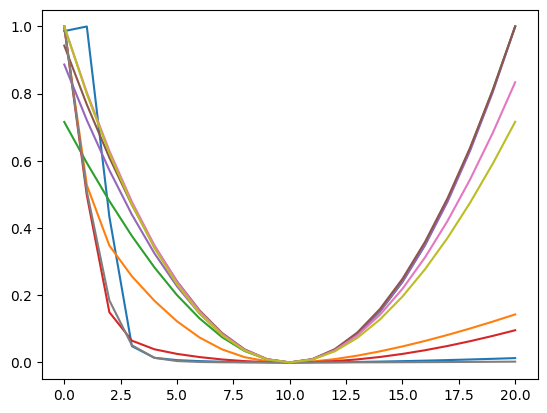

In [59]:
import matplotlib.pyplot as plt

for i, sparsity in enumerate(all_sparsities):
    if kl_divs_max[0, i] < 0.001:
        continue
    if sparsity < -3:
        plt.plot(normalized_kl_divs[:, i])
plt.show()

In [61]:
y = normalized_kl_divs[0] - normalized_kl_divs[-1]
px.scatter(x=all_sparsities, y=y)